In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv
import torch
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
import ot
from tqdm import tqdm
import sys
sys.path.append("../")
from lib.linear_gromov import LGW_dist,LPGW_embedding,LPGW_dist,LGW_dist
from lib.opt import opt_lp,emd_lp
from lib.gromov import gromov_wasserstein, cost_matrix_d, tensor_dot_param, tensor_dot_func, gwgrad_partial1, partial_gromov_wasserstein, partial_gromov_ver1
from lib.gromov import *

from sklearn import manifold
from sklearn.decomposition import PCA

from sklearn.datasets import load_digits
from sklearn.manifold import MDS
import ot

/home/baly/Enter/envs/pot/lib/python3.11/site-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
2000it [00:00, 51058.21it/s]
400it [00:00, 52695.57it/s]
400it [00:13, 30.02it/s]
400it [00:14, 27.70it/s]
400it [00:15, 26.09it/s]
/home/baly/Enter/envs/pot/lib/python3.11/site-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


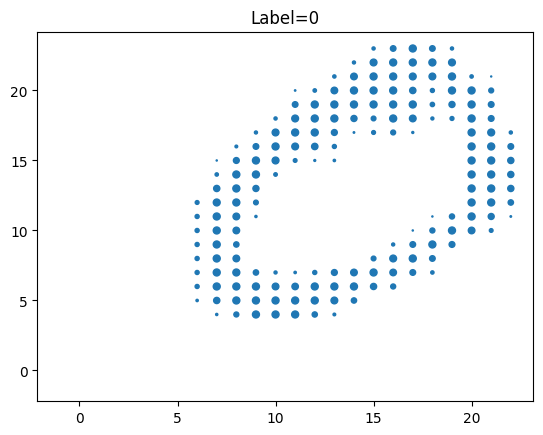

In [3]:
def sample_images_by_label(X, Y, target_label, sample_size=10,rd_seed=0):
    """
    Displays a specified number of random sample images from the MNIST dataset with the given label.

    Parameters:
    X (numpy.ndarray): The MNIST dataset of images.
    Y (numpy.ndarray): The labels corresponding to the images.
    target_label (int): The label of the images to sample.
    sample_size (int): The number of images to display. Default is 10.

    Returns:
    None
    """
    # Find indices of images with the specified label
    indices = np.where(Y == target_label)[0]
    np.random.rand(rd_seed)
    if len(indices) == 0:
        print(f"No images found with label {target_label}.")
        return

    # Adjust sample size if there are fewer images available
    if sample_size > len(indices):
        print(f"Only {len(indices)} images available with label {target_label}. Displaying all.")
        sample_size = len(indices)

    # Randomly select indices from the found indices
    sample_indices = np.random.choice(indices, size=sample_size, replace=False)

    return X[sample_indices], Y[sample_indices]

def split_pmf(X):
    b=X[:,2]
    X1=X[b!=-1,0:2]
    pmf=b[b!=-1]
    pmf=pmf/pmf.sum()
    return X1,pmf

def rotate(X,seed=0):
    X= X- X.mean(0)
    np.random.seed(seed)
    theta=np.random.rand(1)[0]*2*np.pi
    c,s=np.cos(theta),np.sin(theta)
    rot_d=np.array([[c,-s],[s,c]])
    flip = np.random.randint(0,2)
    X_rot=X.dot(rot_d)
    if flip ==1:
        flip_d=np.array([[0,1],[1,0]])
        X_rot=X_rot.dot(flip)
    return X_rot

def add_noise(X,pmf,eta=0,mass=1,seed=0,low_bound=-15,upper_bound=20):
    if eta==0:
        return X,pmf
    
    np.random.seed(seed)
    n_pts = X.shape[0]
    n_noise = int(n_pts * eta)
    mass=pmf.sum()
    mass_noise=eta*mass    
    noise_pts = np.random.randint(low_bound, upper_bound, size=(n_noise, 2))
    pmf_noise=np.ones(n_noise)/n_noise*mass_noise 

    X1=np.concatenate((X,noise_pts))
    pmf1=np.concatenate((pmf,pmf_noise))
    return X1,pmf1

df = pd.read_csv("data/train.csv")
train_X = df[df.columns[1:]].to_numpy()
train_y = df[df.columns[0]].to_numpy()
train_X = train_X.reshape(train_X.shape[0], -1, 3)


ind = 1
plt.scatter(train_X[ind,:,0],train_X[ind,:,1],s=train_X[ind,:,2]*.1)
plt.title('Label=%d'%train_y[ind])

df = pd.read_csv("data/test.csv")
test_X = df[df.columns[1:]].to_numpy()
test_y = df[df.columns[0]].to_numpy()
test_X = test_X.reshape(test_X.shape[0], -1, 3)

                
    





# sample the training data 
def sample_dataset(train_X,train_y,labels=[0,2,4,6],sample_size=500):
    train_X_sample=[]
    train_Y_sample=[]
    train_X_sample_pos=[]
    train_X_sample_pmf=[]
    for label in [0,2,4,6]:
        X_sample,Y_sample=sample_images_by_label(train_X,train_y,label,sample_size=sample_size)
        train_X_sample.append(X_sample)
        train_Y_sample.append(Y_sample)
    train_X_sample,train_Y_sample=np.concatenate(train_X_sample),np.concatenate(train_Y_sample)

    for i,X in tqdm(enumerate(train_X_sample)):
        pos,pmf=split_pmf(X)
        train_X_sample_pos.append(pos)
        train_X_sample_pmf.append(pmf)
    return train_X_sample_pos,train_X_sample_pmf,train_Y_sample

def process_dataset(test_X_sample_pos,test_X_sample_pmf,eta=0):
    test_X_sample_pos1,test_X_sample_pmf1=[],[]
    for i,(pos,pmf) in tqdm(enumerate(zip(test_X_sample_pos,test_X_sample_pmf))):
        pos2=rotate(pos,seed=i)
        pos3,pmf3=add_noise(pos2,pmf,eta=eta,mass=1,seed=0,low_bound=-15,upper_bound=20)
        test_X_sample_pos1.append(pos3)
        test_X_sample_pmf1.append(pmf3)
    return test_X_sample_pos1,test_X_sample_pmf1

# construct training set: 
sample_size=500


train_X_sample_pos,train_X_sample_pmf,train_Y_sample=sample_dataset(train_X,train_y,labels=[0,2,4,6],sample_size=500)
train_sample={}
train_sample['train_X_sample_pos']=train_X_sample_pos
train_sample['train_X_sample_pmf']=train_X_sample_pmf
train_sample['train_Y_sample']=train_Y_sample
torch.save(train_sample,'data/train_sample_%i.pt'%sample_size)


test_X_sample_pos,test_X_sample_pmf,test_Y_sample=sample_dataset(test_X,test_y,labels=[0,2,4,6],sample_size=100)

test_sample={}
test_sample['test_X_sample_pos']=test_X_sample_pos
test_sample['test_X_sample_pmf']=test_X_sample_pmf
test_sample['test_Y_sample']=test_Y_sample
torch.save(test_sample,'data/test_sample_%i.pt'%sample_size)

for eta in [0.1, 0.3,0.5]:
    test_X_sample_pos1,test_X_sample_pmf1=process_dataset(test_X_sample_pos,test_X_sample_pmf,eta)
    test_sample={}
    test_sample['test_X_sample_pos']=test_X_sample_pos1
    test_sample['test_X_sample_pmf']=test_X_sample_pmf1
    test_sample['test_Y_sample']=test_Y_sample
    torch.save(test_sample,'data/test_sample_%i_%0.3f.pt'%(sample_size,eta))

# sample_size=100
# test_X_sample_pos,test_X_sample_pmf,test_Y_sample=sample_dataset(test_X,test_y,labels=[0,2,4,6],sample_size=100)


# # process the testing data 
# eta=0.3
# for i,(pos,pmf) in tqdm(enumerate(zip(test_X_sample_pos,test_X_sample_pmf))):
#     pos,pmf=split_pmf(X)
#     pos2=rotate(pos,seed=0)
#     pos3,pmf3=add_noise(pos2,pmf,eta=eta,mass=1,seed=0,low_bound=-15,upper_bound=20)
    
    


# plt.subplot(1, 1, 1)
# plt.scatter(X3[:,0],X3[:,1])
# plt.title(f"Label: {0}")
# plt.axis('off')




In [10]:
# construct mm_space
def pos_to_mm_space(pos):
    M=np.sqrt(cost_matrix_d(pos,pos))
    height=np.ones(M.shape[0])
    height=height/height.sum()
    return M,height

Ms=[]
sizes=[]
for (pos,pmf) in tqdm(zip(train_X_sample_pos,train_X_sample_pmf)):
    M,height=pos_to_mm_space(pos)
    Ms.append(M)
    sizes.append(pmf.shape[0])
sizes=np.array(sizes)
# compute pmf 
idxs =[i*500 for i in range(4)]
N=int(np.mean(sizes))
Cs=[Ms[idx] for idx in idxs]
ps=[train_X_sample_pmf[idx] for idx in idxs]
height_ref=np.ones(N)/N
M_ref=ot.gromov.gromov_barycenters(N, Cs = Cs,
                                            ps = ps, p = height_ref, lambdas = ot.unif(4), loss_fun='square_loss',
                                            max_iter=100, tol=1e-5,random_state=0,log=False)

mds = MDS(n_components=2, metric=True, dissimilarity='precomputed',random_state=100,normalized_stress='auto')
pos_ref=mds.fit_transform(M_ref)

print('error is',np.sqrt(ot.dist(pos_ref,pos_ref))-M_ref)


2000it [00:00, 2712.36it/s]


KeyboardInterrupt: 

In [ ]:
M_ref

In [4]:

def ot_embeddings(pos_ref,pmf_ref,pos_list,pmf_list):
    embedding_list=[]
    n=pos_ref.shape[0]
    for (pos,pmf) in tqdm(zip(pos_list,pmf_list)):
        embeddiing=lot_embedding(X0, X1, p0, p1, numItermax=500*n, numThreads=10)
        embedding_list.append(embedding)
    return embedding_list



        

/home/baly/Enter/envs/pot/lib/python3.11/site-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
17149it [12:58, 22.02it/s]


KeyboardInterrupt: 

/home/baly/Enter/envs/pot/lib/python3.11/site-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


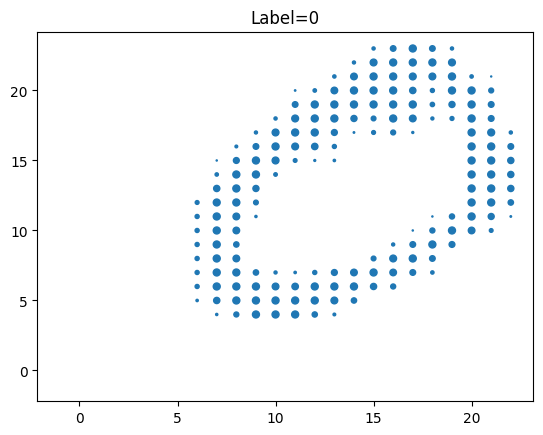

In [9]:

### Load Data
df = pd.read_csv("data/train.csv")
train_X = df[df.columns[1:]].to_numpy()
train_y = df[df.columns[0]].to_numpy()
train_X = train_X.reshape(train_X.shape[0], -1, 3)


ind = 1
plt.scatter(train_X[ind,:,0],train_X[ind,:,1],s=train_X[ind,:,2]*.1)
plt.title('Label=%d'%train_y[ind])

df = pd.read_csv("data/test.csv")
test_X = df[df.columns[1:]].to_numpy()
test_y = df[df.columns[0]].to_numpy()
test_X = test_X.reshape(test_X.shape[0], -1, 3)

del df

### Define Reference

N = 100 # Number of Reference particles
np.random.seed(5)
X = (np.random.rand(N,2)-.5)*20. # Reference

# Xgrid, Ygrid = np.meshgrid(np.linspace(-10,10,10),np.linspace(-10,10,10))
# X = np.stack([Xgrid.reshape(-1),Ygrid.reshape(-1)],1)
a = np.ones(N)/N # Reference mass

### Calculate Embedding
embedd = np.zeros((train_X.shape[0],N,2))
for i,x in tqdm(enumerate(train_X)):
    b = x[:,2]    
    Y = x[b!=-1,:2]
    Y = Y - Y.mean(0)[np.newaxis,:]
    b = b[b!=-1]
    b = b/b.sum()
    C = ot.dist(X,Y)
    Gamma = ot.emd(a,b,C)
    Yhat = (Gamma/a[:,np.newaxis])@Y
    embedd[i,...]=Yhat-X   
embedd_test = np.zeros((test_X.shape[0],N,2))
for i,x in tqdm(enumerate(test_X)):
    b = x[:,2]    
    Y = x[b!=-1,:2]
    Y = Y - Y.mean(0)[np.newaxis,:]
    b = b[b!=-1]
    b = b/b.sum()
    C = ot.dist(X,Y)
    Gamma = ot.emd(a,b,C)
    Yhat = (Gamma/a[:,np.newaxis])@Y
    embedd_test[i,...]=Yhat-X   

### Learn a simple linear classifier on the embedded points
cls = LogisticRegression(max_iter=5000)
cls.fit(embedd.reshape(embedd.shape[0],-1),train_y)
cls.score(embedd_test.reshape(embedd_test.shape[0],-1),test_y)

In [ ]:
clss = 8
inds = np.argwhere(label==clss).squeeze()
N = 100
X = np.random.rand(N,2)-.5
a = np.ones(N)/N
embedd = np.zeros((len(inds),N,2))
for i,ind in enumerate(inds):
    b = Data[ind,:,2]    
    Y = Data[ind,b!=-1,:2]
    Y = Y - Y.mean(0)[np.newaxis,:]
    b = b[b!=-1]
    b = b/b.sum()
    C = ot.dist(X,Y)
    Gamma = ot.emd(a,b,C)
    Yhat = (Gamma/a[:,np.newaxis])@Y
    embedd[i,...]=Yhat-X    
pca = PCA(n_components=4)
pca.fit(embedd.reshape(len(inds),-1))

fig = plt.figure(figsize=(15,3))
for i,y in enumerate(np.linspace(-50,50,4)):    
    for t in np.linspace(-2,2,5):
        Xhat = X+pca.mean_.reshape(100,2)+t*np.sqrt(pca.explained_variance_[i])*pca.components_[i,...].reshape(100,2)
        plt.scatter(Xhat[:,0]+(1-t)*(-25)+t*25,Xhat[:,1]+y,s=a*200,c='C%d'%i,alpha=.5)
plt.axis('off')     
plt.title('OT')